<a href="https://colab.research.google.com/github/yannickshaofengsun/CNN-MPM-denoise/blob/main/d_cnn_complet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D CNN pipline

1) Import librarys 

2) set directory where the dataset is

3) Import dataset

4) creat synthetic data

5) creat and train network

6) result + visualization

In [ ]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
from torch.utils.data import TensorDataset, DataLoader
import random

# for reading and displaying images
from PIL import Image
import matplotlib.pyplot as plt
import time
from skimage.io import imread
from matplotlib.pyplot import figure
import tifffile
import random
# for creating validation set
from sklearn.model_selection import train_test_split


#TENSORBOARD
#import sys
#import torch.nn.functional as F
#from torch.utils.tensorboard import SummaryWriter


In [ ]:
def train_test_index(l_len, train_p, l_exi= False ):
    if l_exi == False:
        x = [l for l in range(l_len)]
        random.shuffle(x)
        test_start = int(l_len * train_p)
    else:
        x = l_len 
        random.shuffle(x)
        test_start = int(len(x)*train_p)
    train_list = x[:test_start]
    test_list = x[test_start:]
    return (train_list, test_list)
def ele_selec(img, l_index):
    res = []
    for ind in l_index:
        res.append(img[ind])
    return res

In [ ]:
#for data importation from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## image dictionanry and parameters 

In [ ]:
folder_path = './drive/MyDrive/stage Inria 2021/crop_ele/'
max_file = folder_path + 'max_c'
min_file = folder_path + 'min_c'

norm_factor = 4000  # measured maixume pixel values of all the real data

## Import beads image

In [ ]:
def file_name(file_path):
    f_name = []
    for folderName, subfolders, filenames in os.walk(file_path):
        filenames = np.sort(filenames)
        for filename in filenames:
            img_path = os.path.join(file_path, filename)
            f_name.append(img_path)
    return f_name

def loade_path(path, z= 20, y = 10, x = 10, norm = 4000):
    data= torch.zeros(len(path), 1, z, y, x)
    for i , ele in enumerate(path):
        im_read =  tifffile.imread(ele)/norm 
        ele_tor = torch.from_numpy(im_read)
        ele_nn = ele_tor.expand(1, -1, -1, -1)
        data[i,:,:,:,:] = ele_nn
    return data


In [ ]:
file_name_max = file_name(max_file)
file_name_min = file_name(min_file)

data_max = loade_path(file_name_max, norm = 4000)
data_min = loade_path(file_name_min, norm = 4000)

## Function for disk and elips

In [ ]:
def disk_3d(z_len, y_len, x_len, r):
    y_rand, x_rand = random.choice([-1, 0, 1]), random.choice([-1, 0, 1])
    z_r = np.random.randn(1)*1.5
    #z_rand = np.int64(z_r if abs(z_r) < 5 else np.sign(z_r)*5)
    
    z_rand = random.choice([i for i in range(-6,7)]) # distrib equilibre entre -5 et 5 
    z, y, x = np.ogrid[-z_len: z_len, -y_len: y_len, -x_len: x_len]
    z_r, y_r, x_r = z + z_rand, y + y_rand, x + x_rand
    mask = x_r**2 + y_r**2 + z_r**2 <= r**2

    mask = 1 * mask.astype(float) 
    return np.array(mask)

def elip_3d(z_len, y_len, x_len, r):
    y_rand, x_rand = random.choice([-1, 0, 1]), random.choice([-1, 0, 1])
    z_r = np.random.randn(1)*1.5
    z_rand = np.int64(z_r if abs(z_r) < 5 else np.sign(z_r)*5)
    a, b, c = random.uniform(0.9, 1.1), random.uniform(
        0.9, 1.1), random.uniform(0.9, 1.1)
    
    z, y, x = np.ogrid[-z_len: z_len, -y_len: y_len, -x_len: x_len]
    
    thera = random.uniform(0, np.pi)
    alpha = random.uniform(0, 2 * np.pi)
    z_r, y_r, x_r = z + z_rand, y + y_rand, x + x_rand
    mask = (x_r/a)**2 + (y_r/b)**2 + (z_r/c)**2 <= r**2
    mask = 1*mask.astype(float)
    return np.array(mask)

def display_img_norm(img, name = "disk"):
    fig, axs = plt.subplots(2,10, figsize=(20, 4))
    axs = axs.ravel()
    v_min = min(img.flat)
    v_max = max(img.flat)
    for x in range(20):
        axs[x].imshow(img[x], vmin = v_min, vmax = v_max)
    fig.suptitle(name)

# changed to pixel wise noise generation 
def add_noise(img_np, var = 0.0093, the = 4000, clean_mean = 250):
    """
    noise variance = var estimated * pixel intenisite / (normalization factor ** 2)
    """
    flat_mask = img_np.flatten()
    z,y,x = img_np.shape
    for i in range(len(flat_mask)):
        gauss_noise = random.gauss(0,np.sqrt(var * clean_mean * flat_mask[i] / (the)))
        flat_mask[i] += gauss_noise
                
    return flat_mask.reshape(z,y,x)


## Disk visualization and simulation dataset generation 

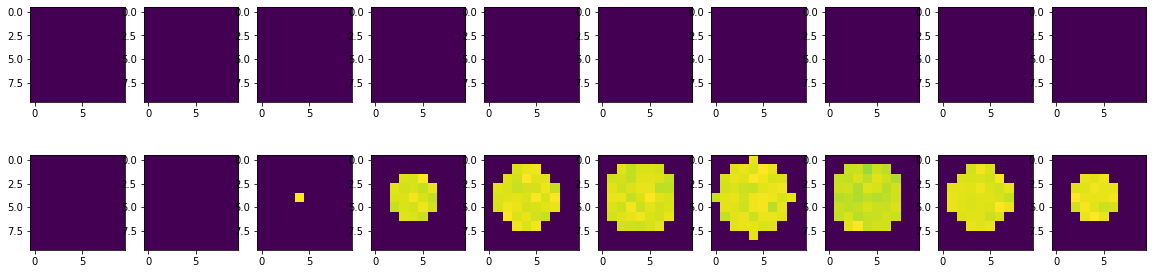

In [ ]:
disk_cir = disk_3d(10, 5, 5, 4)
noise_cir = add_noise(disk_cir)
fig, axs = plt.subplots(2,10, figsize=(20,5))
axs = axs.ravel()
for z in range(20):
    axs[z].imshow(noise_cir[z])

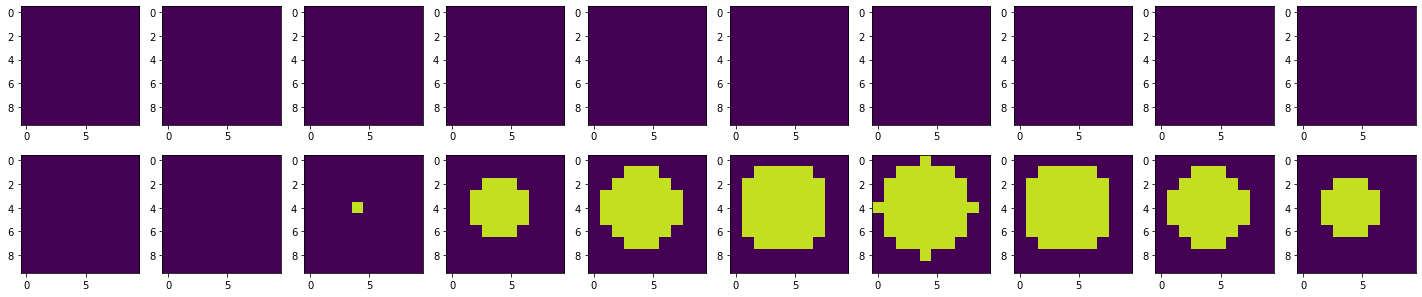

In [ ]:
fig, axs = plt.subplots(2,10, figsize=(25,5))
axs = axs.ravel()
for z in range(20):
    axs[z].imshow(disk_cir[z], vmax= 1.1)

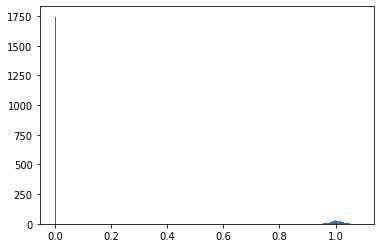

In [ ]:
_  = plt.hist(noise_cir.flatten(),200)

In [ ]:
def add_torch_cir (n, z_len = 10, y_len = 5, x_len = 5, r = 4):
    syn_clean, syn_noise = torch.zeros(n,1, 20, 10, 10), torch.zeros(n, 1,20, 10, 10)    
    for j in range (n):
        disk1 = disk_3d(z_len, y_len, x_len, r)
        noise_ = add_noise(disk1)
        ele_tor = torch.from_numpy(disk1)
        ele_tor_n = torch.from_numpy(noise_)
        ele_nn = ele_tor.expand(-1, -1, -1)
        ele_nn_n = ele_tor_n.expand(-1, -1, -1)
        syn_clean[j,0,:,:,:] =  ele_nn
        syn_noise[j,0,:,:,:] =  ele_nn_n
    return syn_clean, syn_noise

def add_torch_elip (n, z_len = 10, y_len = 5, x_len = 5, r = 4):
    syn_clean, syn_noise = torch.zeros(n,1, 20, 10, 10), torch.zeros(n, 1,20, 10, 10) #Number of element, in channel, z, y, x
    for j in range (n):
        elip1 = elip_3d(z_len, y_len, x_len, r)
        noise_ = add_noise(elip1)
        ele_tor = torch.from_numpy(elip1)
        ele_tor_n = torch.from_numpy(noise_)
        ele_nn = ele_tor.expand( -1, -1, -1)
        ele_nn_n = ele_tor_n.expand( -1, -1, -1)
        syn_clean[j,0,:,:,:] =  ele_nn
        syn_noise[j,0,:,:,:] =  ele_nn_n
    return syn_clean, syn_noise
        


In [ ]:
def disp_img_nn_res(img_bruit, img_clean, img_res):
    bruit = img_bruit.cpu().detach().numpy()
    clean = img_clean.cpu().detach().numpy()
    res = img_res.cpu().detach().numpy()

    v_min = min(min(bruit.flat), min(clean.flat), min(res.flat))
    v_max = max(max(bruit.flat), max(clean.flat), max(res.flat))
    fig, axs = plt.subplots(20,3, figsize=(15, 80)) #fig, axs = plt.subplots(10,6, figsize=(25, 40))
    axs = axs.ravel()
    #v_max = max(max(bruit.flat), max(clean.flat), max(res.flat))
    for count in range(0, 60, 3):
        #v_min = min(min(bruit[int(count/3)].flat), min(clean[int(count/3)].flat), min(res[int(count/3)].flat))
        #v_max = max(max(bruit[int(count/3)].flat), max(clean[int(count/3)].flat), max(res[int(count/3)].flat))
        axs[0 + count].imshow(bruit[int(count/3)], cmap = 'gray' , vmin = 0, vmax = v_max)
        axs[0 + count].set_title('image noisy, z = ' + str(count/3) )
        axs[1 + count].imshow(clean[int(count/3)], cmap = 'gray', vmin = 0, vmax = v_max)
        axs[1 + count].set_title('image clean, z = '+ str(count/3))
        axs[2 + count].imshow(res[int(count/3)], cmap = 'gray', vmin = 0, vmax = v_max)
        axs[2 + count].set_title('image denoised'+', z ='+ str(count/3))

In [ ]:
def simu_dataset_generator(n_cir, n_elip, r_c = 4, r_e = 4): 
    syn_cir, syn_cir_noise = add_torch_cir(n_cir, r = r_c)
    syn_elip, syn_elip_noise = add_torch_elip(n_elip, r = r_e)

    syn_clean = torch.zeros(n_cir+n_elip , 1, 20,10,10) 
    #index: number of images, number of channels, z, y, x
    syn_clean[:n_cir, :, :, :, :] = syn_cir 
    syn_clean[n_cir:,:,:,:,:] = syn_elip

    
    syn_noise = torch.zeros(n_cir+n_elip,1,20,10,10)
    syn_noise[:n_cir,:,:,:,:] = syn_cir_noise
    syn_noise[n_cir:,:,:,:,:] = syn_elip_noise
    return syn_clean, syn_noise

In [ ]:
def dataset_gen (n_c, n_elip, r_c, r_e ):
    clean, noise = simu_dataset_generator(n_c, n_elip, r_c, r_e) # created function 
    dataset = TensorDataset(clean, noise) # pytorch function combine two tensor dataset 
    return dataset

In [ ]:
#loader = DataLoader(dataset, batch_size = b_size, shuffle = True)

## Creat dataset for training validation and test

In [ ]:
reald_dataset = TensorDataset(data_max, data_min)
reald_loader = DataLoader(reald_dataset, batch_size = data_min.shape[0], shuffle = True)

In [ ]:
train_real_set, else_set = torch.utils.data.random_split(reald_dataset, [47, 30])
val_real_set, test_real_set = torch.utils.data.random_split(else_set, [15, 15])

In [ ]:
val_sim_set = dataset_gen(75, 75, 4, 4)
train_sim_set = dataset_gen(1000,0, 4, 0)
train_sim_mix_set = dataset_gen(500,500,4,4)

In [ ]:
disk_cir = disk_3d(10, 5, 5, 4)
noise_cir = add_noise(disk_cir)

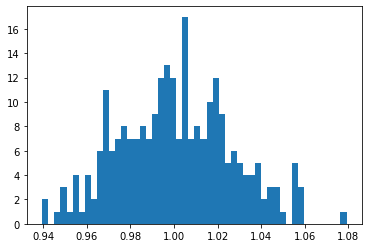

In [ ]:
_ = plt.hist(noise_cir.flatten()[noise_cir.flatten()>0], 50)

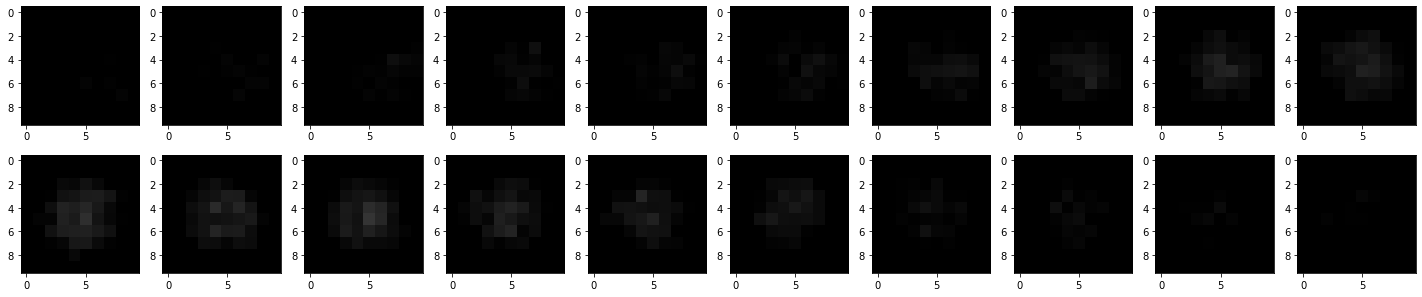

In [ ]:
for x,y in val_real_set:
  pass
fig, axs = plt.subplots(2,10, figsize=(25,5))
axs = axs.ravel()
for z in range(20):
    axs[z].imshow(x[0,z], vmax = 0.9, cmap = 'gray')

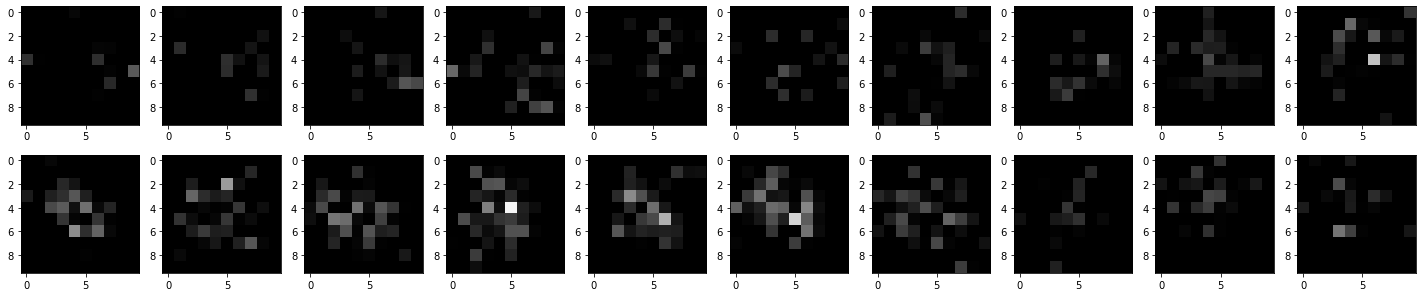

In [ ]:
fig, axs = plt.subplots(2,10, figsize=(25,5))
axs = axs.ravel()
for z in range(20):
    axs[z].imshow(y[0,z], vmax = 0.9, cmap = 'gray')
  

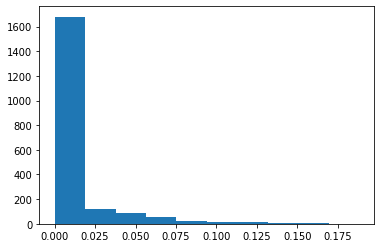

In [ ]:
_ = plt.hist(x.flatten())

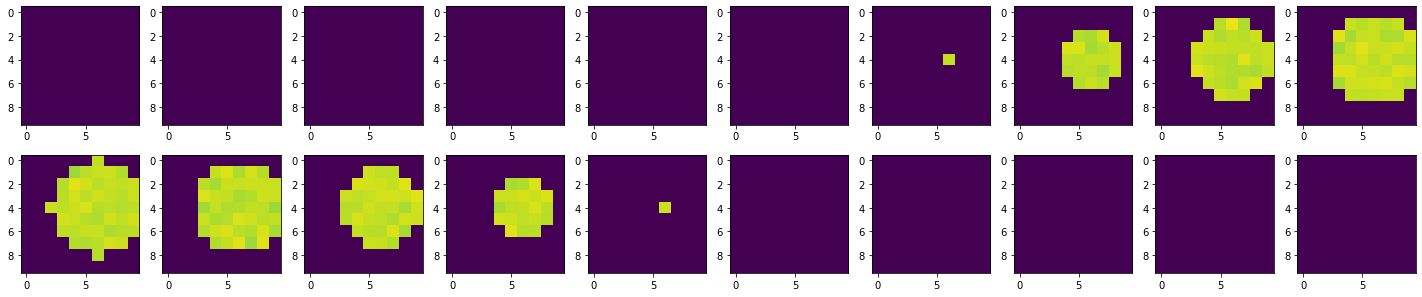

In [ ]:
disk_cir = disk_3d(10, 5, 5, 4)
noise_cir = add_noise(disk_cir)
fig, axs = plt.subplots(2,10, figsize=(25,5))
axs = axs.ravel()
for z in range(20):
    axs[z].imshow(noise_cir[z], vmax= 1.1)

## Dncnn model 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

input_size = 20 *10 * 10 # z * y * x

class DnCNN3d(nn.Module):
    def __init__(self, in_nc=1, out_nc=1, nc=5, num_of_layers=17) : # channels, num_of_layers=10):
        super(DnCNN3d, self).__init__()
        kernel_size = 3
        padding = 1
        self.layers = []
        
        conv1 = nn.Conv3d(in_channels=in_nc, out_channels=nc, kernel_size=kernel_size, padding=padding, bias=False)
        conv1.weight.data.fill_(1/9)
        self.layers.append(conv1)
        self.layers.append(nn.ReLU(inplace=True))
        

        for _ in range(num_of_layers-2):
            self.layers.append(nn.Conv3d(in_channels=nc, out_channels=nc, kernel_size=kernel_size, padding=padding, bias=False))
            #self.layers.append(nn.BatchNorm3d(features))
            self.layers.append(nn.ReLU(inplace=True))
        
        conv_end = nn.Conv3d(in_channels=nc, out_channels=out_nc, kernel_size=kernel_size, padding=padding, bias=False)

        self.layers.append(conv_end)
        self.dncnn3d = nn.Sequential(*self.layers)
        
        
    def forward(self, x):
        out = self.dncnn3d(x)
        #add an relu layer to keep the result image to be positive
        res = F.relu(x - out)
        return res
   
   

cuda


In [ ]:
class DnCNN3d_de(nn.Module):
    def __init__(self, in_nc=1, out_nc=1, nc=5, num_of_layers=17) : # channels, num_of_layers=10):
        super(DnCNN3d_de, self).__init__()
        kernel_size = 3
        padding = 1
        self.layers = []
        
        conv1 = nn.Conv3d(in_channels=in_nc, out_channels=nc, kernel_size=kernel_size, padding=padding, bias=False)
        conv1.weight.data.fill_(1/9)
        self.layers.append(conv1)
        self.layers.append(nn.ReLU(inplace=True))
        

        for _ in range(num_of_layers-2):
            self.layers.append(nn.Conv3d(in_channels=nc, out_channels=nc, kernel_size=kernel_size, padding=padding, bias=False))
            #self.layers.append(nn.BatchNorm3d(features))
            self.layers.append(nn.ReLU(inplace=True))
        
        conv_end = nn.Conv3d(in_channels=nc, out_channels=out_nc, kernel_size=kernel_size, padding=padding, bias=False)

        self.layers.append(conv_end)
        self.dncnn3d = nn.Sequential(*self.layers)
        
        
    def forward(self, x):
        out = self.dncnn3d(x)
        #add an relu layer to keep the result image to be positive
        res = x - out
        return res

## creat dataset and data loader 

In [ ]:
train_sets = [train_sim_set, train_real_set]

In [ ]:
train_sim_loader_5 = DataLoader(
    train_sim_set,
    shuffle=True,
    num_workers=0,
    batch_size = 5
)
train_real_loader_5 = DataLoader(
    train_real_set,
    shuffle=True,
    num_workers=0,
    batch_size = 5
)

train_sim_loader_10 = DataLoader(
    train_sim_set,
    shuffle=True,
    num_workers=0,
    batch_size = 10
)
train_real_loader_10 = DataLoader(
    train_real_set,
    shuffle=True,
    num_workers=0,
    batch_size = 10
)

In [ ]:
train_sim_mix_loader_10 = DataLoader(
    train_sim_mix_set,
    shuffle=True,
    num_workers=0,
    batch_size = 10
)

In [ ]:
val_sets = [val_sim_set, val_real_set]
val_set_mix = torch.utils.data.ConcatDataset(val_sets)
val_mix_loader = DataLoader(
    val_set_mix,
    shuffle=False,
    num_workers=0,
    batch_size = 200
)

val_reel_loader = DataLoader(
    val_real_set,
    shuffle=False,
    num_workers=0,
    batch_size = 50
)

In [ ]:
test_reel_loader = DataLoader(
    test_real_set,
    shuffle=False,
    num_workers=0,
    batch_size = 50
)

In [ ]:
criterion = nn.MSELoss(size_average = True) #size_averge give norm 

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Train function 

In [ ]:
def train(history, model, train_set, val_set_mix, val_set_reel, nb_epoch,lr_new, lr_update = True, gam = 0.9, early_stop = True, step = 100):
    optimizer = torch.optim.Adam(model.parameters(), lr = lr_new)
    
    if lr_update == "step":
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step, gamma= gam)
    elif lr_update == 'plateau':
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = gam )
    else:
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 1)
        
    t0 = time.time()
    for epoch in range(1,nb_epoch+1):
        #train set
        for clean, noise in train_set:
            optimizer.zero_grad()
            res = model(noise.to(device))
            loss = criterion(res, clean.to(device)) 
            # Backward and optimizer
            loss.backward()
            optimizer.step()
        
        # compute loss
        with torch.no_grad():
            nb_batch = 0
            running_loss = 0
            for clean, noise in train_set:
                res = model(noise.to(device))
                loss = criterion(res, clean.to(device))
                running_loss += loss.item() 
                nb_batch += 1
            history['loss_train'].append(running_loss/ nb_batch)
        
        # validation set 1
        with torch.no_grad():
            nb_batch = 0
            running_loss = 0
            for clean, noise in val_set_mix:
                res = model(noise.to(device))
                loss = criterion(res, clean.to(device))
                running_loss += loss.item() 
                nb_batch += 1
            history['loss_val_mix'].append(running_loss/ nb_batch)
        
        # validation set 2
        with torch.no_grad():
            nb_batch = 0
            running_loss = 0
            for clean, noise in val_set_reel:
                res = model(noise.to(device))
                loss = criterion(res, clean.to(device))
                running_loss += loss.item() 
                nb_batch += 1
            history['loss_val_reel'].append(running_loss/ nb_batch)

            
        #condition for early stopping 
        if early_stop:
            if len(history['loss_train']) > 10 and history['loss_train'][-1] > history['loss_train'][-10]:
                print('early break, epoch = ', epoch)
                break
            elif len(history['loss_val']) > 10  and (history['loss_val'][-1] > history['loss_val'][-10]):
                print('overfit, epoch = ', epoch)
                break
        
        if epoch == 1:
            print('one epoch time = {:.2e} seconds'.format(time.time() - t0))
            print('epoch {} with loss train {:.2e}, loss validition mix= {:.2e}, loss validition reel= {:.2e}'.format(epoch, 
                                                                                 history['loss_train'][-1], 
                                                                                 history['loss_val_mix'][-1],
                                                                                 history['loss_val_reel'][-1]))
        if epoch % 50==0:
            print('epoch {} : loss train {:.2e}, loss validition mix = {:.2e}, loss validition reel= {:.2e}, Current learning rate {:.2e}'.format(epoch,
                                                                                                            history['loss_train'][-1], 
                                                                                                            history['loss_val_mix'][-1],
                                                                                                            history['loss_val_reel'][-1],
                                                                                                            optimizer.param_groups[0]['lr']))
        #update learning rate:
        scheduler.step(loss)
    print('epoch {} : loss train {:.2e} and loss val = {:.2e}, loss validition reel= {:.2e}'.format(epoch, history['loss_train'][-1], 
                                                                                                            history['loss_val_mix'][-1],
                                                                                                            history['loss_val_reel'][-1]))
    print('training time = {:.2e} min'.format((time.time() - t0)/60))
    
    
    return history 

In [ ]:
def plot_loss_2(history, fig_size = (15,5)):
    figure(figsize = fig_size, dpi=80)
    train = history['loss_train']
    val_mix = history['loss_val_mix']
    val_reel = history['loss_val_reel']
    
    plt.plot(train, label = "train loss")
    plt.plot(val_mix, label = "validation mixture set loss ")
    plt.plot(val_reel, label = "validation real data set loss ")
    plt.legend()

# Model 5 channel, 8 layer with batch size of 10

In [ ]:
dncnn3d_5_8_10_de_new = DnCNN3d_de(nc = 5, num_of_layers = 8).to(device)
criterion = nn.MSELoss(size_average = True)
history_dncnn = {'loss_train' : [], 'loss_val_mix': [], 'loss_val_reel':[]}

history_5_8_10_de_new = train(history_dncnn, dncnn3d_5_8_10_de_new, train_sim_loader_10, val_mix_loader, val_reel_loader,
                              nb_epoch = 600 ,lr_new = 0.0001,lr_update = "plateau", gam = 0.92, early_stop = False )

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


one epoch time = 1.65e+00 seconds
epoch 1 with loss train 7.44e-05, loss validition mix= 9.13e-04, loss validition reel= 9.27e-03
epoch 50 : loss train 6.14e-05, loss validition mix = 9.13e-04, loss validition reel= 8.90e-03, Current learning rate 9.20e-05
epoch 100 : loss train 5.03e-05, loss validition mix = 9.10e-04, loss validition reel= 8.45e-03, Current learning rate 9.20e-05
epoch 150 : loss train 3.99e-05, loss validition mix = 8.89e-04, loss validition reel= 8.02e-03, Current learning rate 9.20e-05
epoch 200 : loss train 3.09e-05, loss validition mix = 8.65e-04, loss validition reel= 7.57e-03, Current learning rate 9.20e-05
epoch 250 : loss train 2.40e-05, loss validition mix = 8.46e-04, loss validition reel= 7.18e-03, Current learning rate 9.20e-05
epoch 300 : loss train 1.99e-05, loss validition mix = 8.23e-04, loss validition reel= 6.92e-03, Current learning rate 9.20e-05
epoch 350 : loss train 1.72e-05, loss validition mix = 8.06e-04, loss validition reel= 6.75e-03, Curren

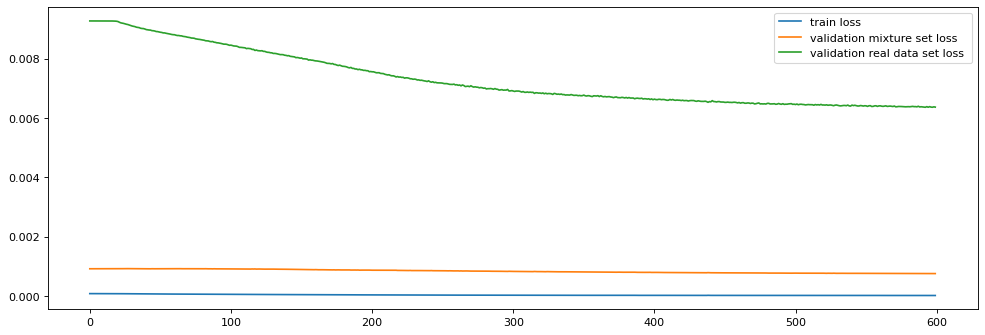

In [ ]:
plot_loss_2(history_5_8_10_de_new)
#figure(figsize=(20,10), dpi=80)
#plt.plot(history_5_8_10_de_new['loss_train'][200:])
#plt.plot(history_5_8_10_de_new['loss_val'][200:])

Text(0, 0.5, 'Valeur de la MSE par pixel en log')

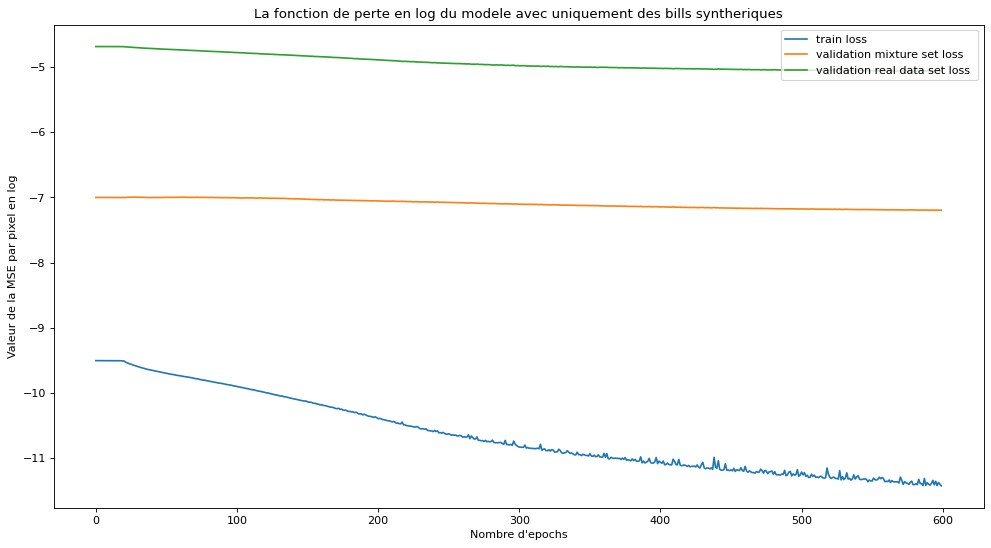

In [ ]:

figure(figsize=(15,8), dpi=80)
plt.plot(np.log(history_5_8_10_de_new['loss_train'][:600]), label = "train loss")
plt.plot(np.log(history_5_8_10_de_new['loss_val_mix'][:600]), label = "validation mixture set loss ")
plt.plot(np.log(history_5_8_10_de_new['loss_val_reel'][:600]), label = "validation real data set loss ")
plt.legend(loc="upper right")
plt.title("La fonction de perte en log du modele avec uniquement des bills syntheriques")
plt.xlabel("Nombre d'epochs")
plt.ylabel("Valeur de la MSE par pixel en log")

## fin tuning 

In [ ]:
history_5_8_10_de_new = train(history_5_8_10_de_new, dncnn3d_5_8_10_de_new, train_real_loader_5 , val_mix_loader, val_reel_loader,
                                                   nb_epoch=800 ,lr_new = 0.00001,lr_update = "plateau", gam = 0.92, early_stop = False )

one epoch time = 1.02e-01 seconds
epoch 1 with loss train 6.02e-03, loss validition mix= 8.18e-04, loss validition reel= 6.17e-03
epoch 50 : loss train 2.17e-03, loss validition mix = 6.32e-02, loss validition reel= 2.13e-03, Current learning rate 1.00e-05
epoch 100 : loss train 1.90e-03, loss validition mix = 6.44e-02, loss validition reel= 1.90e-03, Current learning rate 1.00e-05
epoch 150 : loss train 1.76e-03, loss validition mix = 5.99e-02, loss validition reel= 1.80e-03, Current learning rate 1.00e-05
epoch 200 : loss train 1.69e-03, loss validition mix = 6.18e-02, loss validition reel= 1.71e-03, Current learning rate 1.00e-05
epoch 250 : loss train 1.60e-03, loss validition mix = 6.01e-02, loss validition reel= 1.64e-03, Current learning rate 1.00e-05
epoch 300 : loss train 1.61e-03, loss validition mix = 6.51e-02, loss validition reel= 1.59e-03, Current learning rate 1.00e-05
epoch 350 : loss train 1.52e-03, loss validition mix = 5.91e-02, loss validition reel= 1.56e-03, Curren

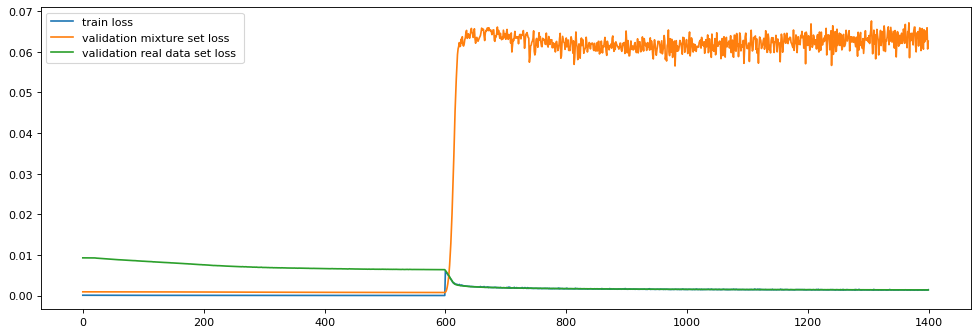

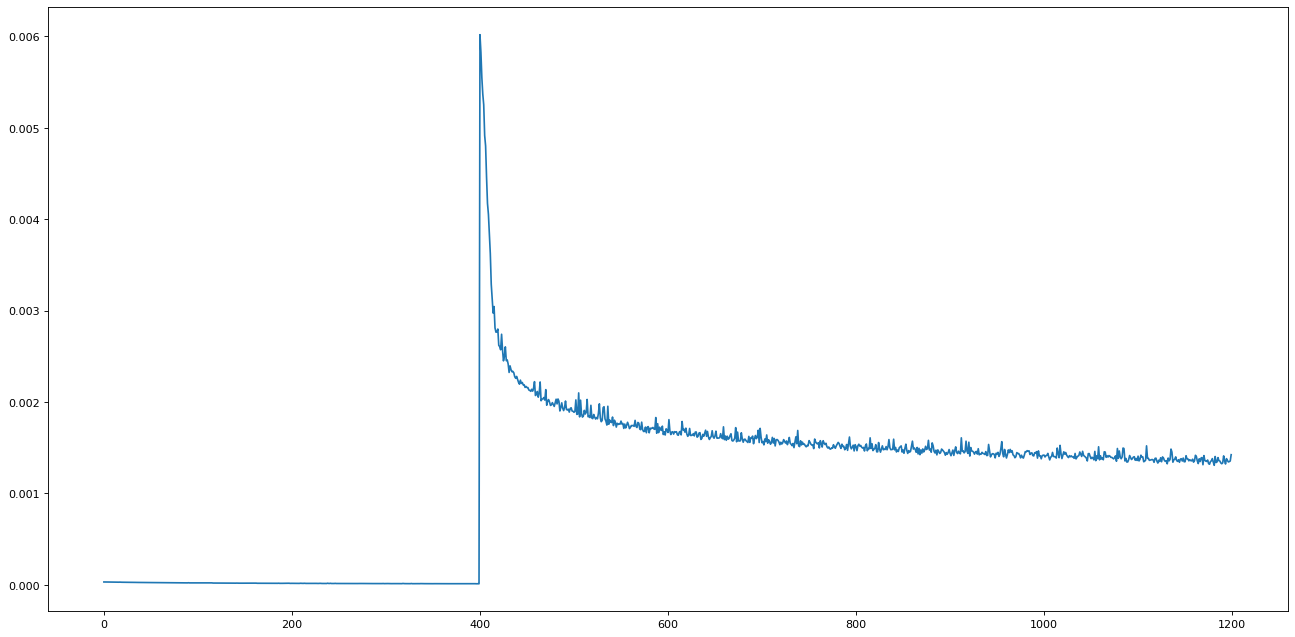

In [ ]:
plot_loss_2(history_5_8_10_de_new)
figure(figsize=(20,10), dpi=80)
plt.plot(history_5_8_10_de_new['loss_train'][200:])
#plt.plot(history_5_8_10_de_new['loss_val_mix'][400:])
#plt.plot(history_5_8_10_de_new['loss_val_reel'][200:])

Text(0, 0.5, 'Valeur de la MSE par pixel')

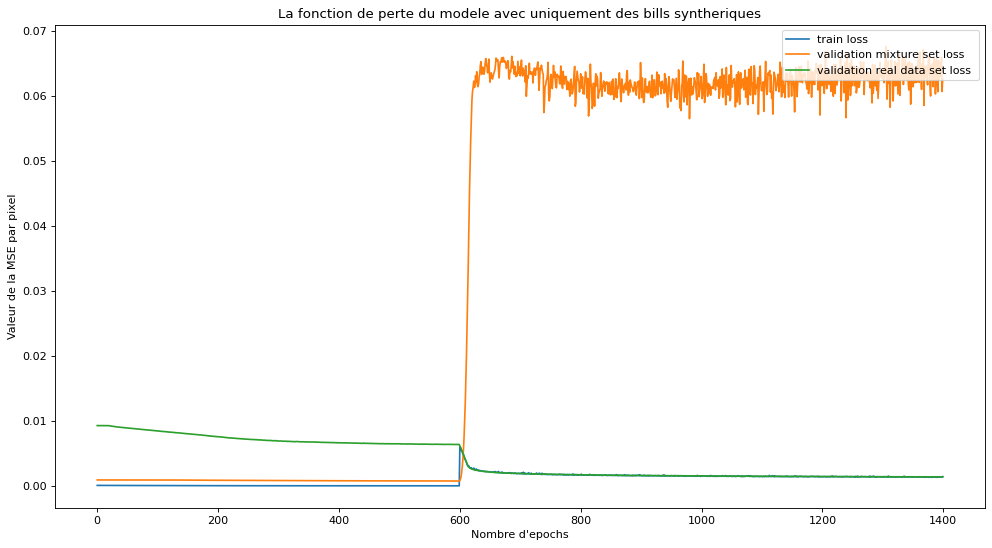

In [ ]:
figure(figsize=(15,8), dpi=80)
plt.plot(history_5_8_10_de_new['loss_train'][:], label = "train loss")
plt.plot(history_5_8_10_de_new['loss_val_mix'][:], label = "validation mixture set loss ")
plt.plot(history_5_8_10_de_new['loss_val_reel'][:], label = "validation real data set loss ")
plt.legend(loc="upper right")
plt.title("La fonction de perte du modele avec uniquement des bills syntheriques")
plt.xlabel("Nombre d'epochs")
plt.ylabel("Valeur de la MSE par pixel")

# show result 

In [ ]:
with torch.no_grad():
    for clean, noise in test_reel_loader:
        res = dncnn3d_5_8_10_de_new(noise.to(device))

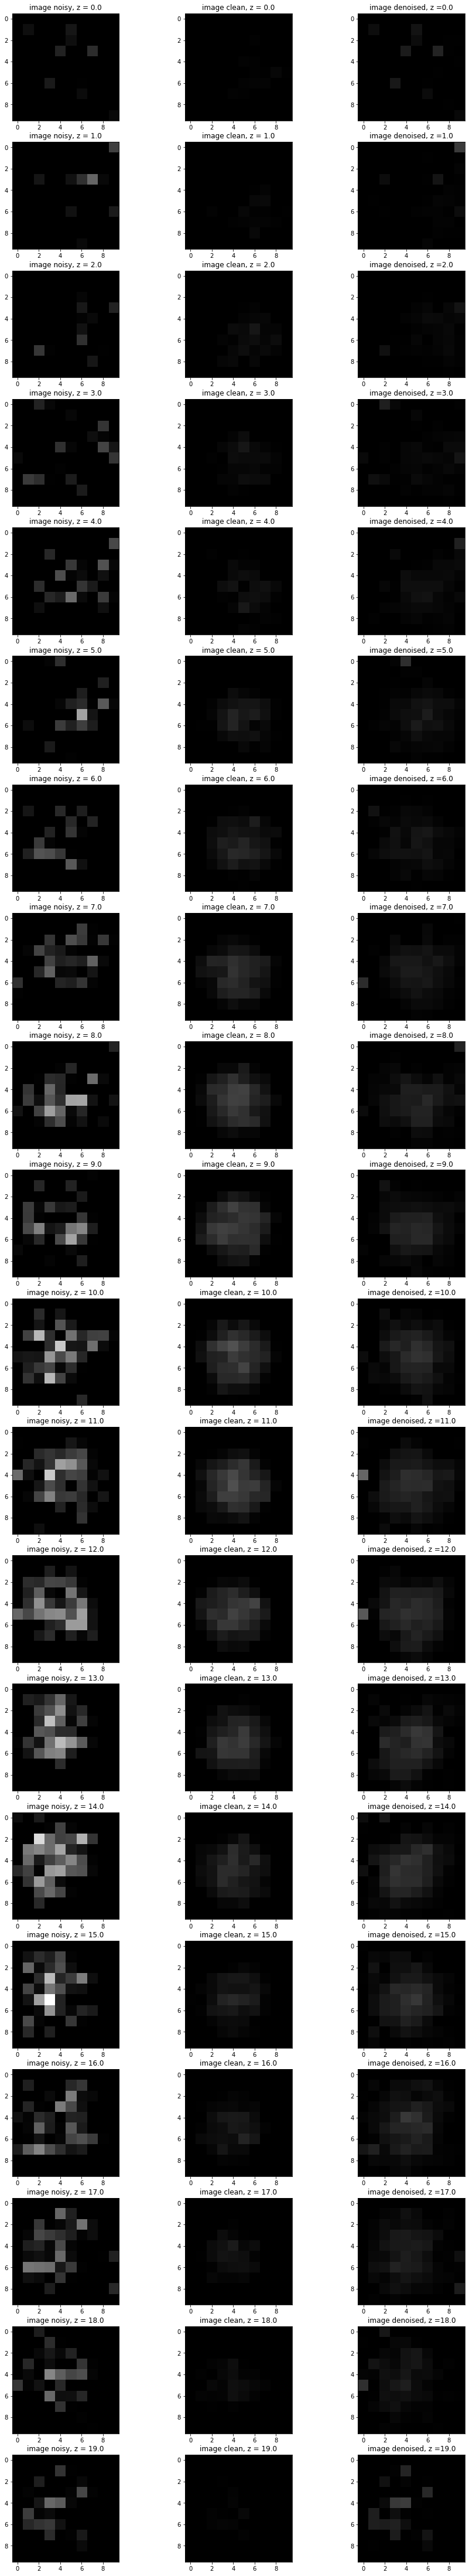

In [ ]:
disp_img_nn_res(noise[2,0], clean[2,0], res[2,0])

# same network with mixture of beads and eliposide 

In [ ]:
dncnn3d_5_8_10_de_mix = DnCNN3d_de(nc = 5, num_of_layers = 8).to(device)
criterion = nn.MSELoss(size_average = True)
history_dncnn = {'loss_train' : [], 'loss_val_mix': [], 'loss_val_reel':[]}

history_5_8_10_de_mix = train(history_dncnn, dncnn3d_5_8_10_de_mix, train_sim_mix_loader_10, val_mix_loader, val_reel_loader,
                              nb_epoch = 600 ,lr_new = 0.0001,lr_update = "plateau", gam = 0.92, early_stop = False )

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


one epoch time = 1.30e+00 seconds
epoch 1 with loss train 7.57e-05, loss validition mix= 9.13e-04, loss validition reel= 9.27e-03
epoch 50 : loss train 6.32e-05, loss validition mix = 8.79e-04, loss validition reel= 9.03e-03, Current learning rate 1.00e-04
epoch 100 : loss train 5.07e-05, loss validition mix = 8.60e-04, loss validition reel= 8.95e-03, Current learning rate 9.20e-05
epoch 150 : loss train 3.91e-05, loss validition mix = 8.26e-04, loss validition reel= 8.69e-03, Current learning rate 9.20e-05
epoch 200 : loss train 2.66e-05, loss validition mix = 7.51e-04, loss validition reel= 7.99e-03, Current learning rate 9.20e-05
epoch 250 : loss train 2.02e-05, loss validition mix = 6.97e-04, loss validition reel= 7.46e-03, Current learning rate 9.20e-05
epoch 300 : loss train 1.69e-05, loss validition mix = 6.65e-04, loss validition reel= 7.14e-03, Current learning rate 9.20e-05
epoch 350 : loss train 1.50e-05, loss validition mix = 6.48e-04, loss validition reel= 6.98e-03, Curren

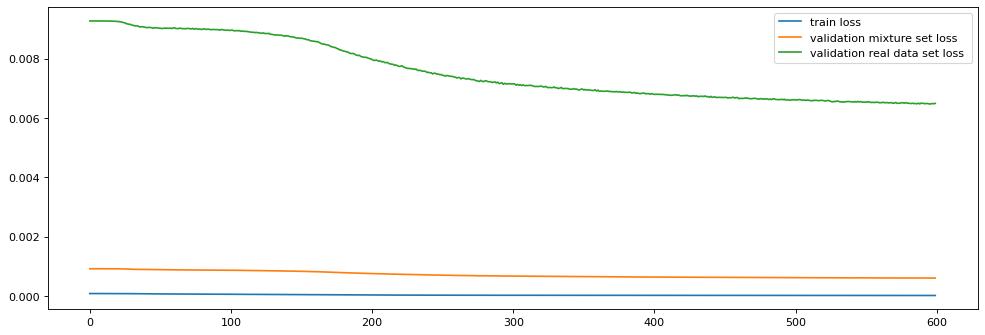

In [ ]:
plot_loss_2(history_5_8_10_de_mix)

In [ ]:
history_5_8_10_de_mix = train(history_5_8_10_de_mix, dncnn3d_5_8_10_de_mix, train_real_loader_5 , val_mix_loader, val_reel_loader,
                                                   nb_epoch=800 ,lr_new = 0.0001,lr_update = "plateau", gam = 0.92, early_stop = False )

one epoch time = 9.80e-02 seconds
epoch 1 with loss train 4.52e-03, loss validition mix= 3.30e-03, loss validition reel= 4.58e-03
epoch 50 : loss train 1.23e-03, loss validition mix = 6.51e-02, loss validition reel= 1.20e-03, Current learning rate 1.00e-04
epoch 100 : loss train 1.10e-03, loss validition mix = 6.98e-02, loss validition reel= 1.07e-03, Current learning rate 1.00e-04
epoch 150 : loss train 9.45e-04, loss validition mix = 7.47e-02, loss validition reel= 9.85e-04, Current learning rate 1.00e-04
epoch 200 : loss train 9.20e-04, loss validition mix = 6.83e-02, loss validition reel= 9.58e-04, Current learning rate 1.00e-04
epoch 250 : loss train 8.74e-04, loss validition mix = 7.42e-02, loss validition reel= 9.13e-04, Current learning rate 9.20e-05
epoch 300 : loss train 8.37e-04, loss validition mix = 9.21e-02, loss validition reel= 8.64e-04, Current learning rate 9.20e-05
epoch 350 : loss train 8.04e-04, loss validition mix = 8.85e-02, loss validition reel= 8.28e-04, Curren

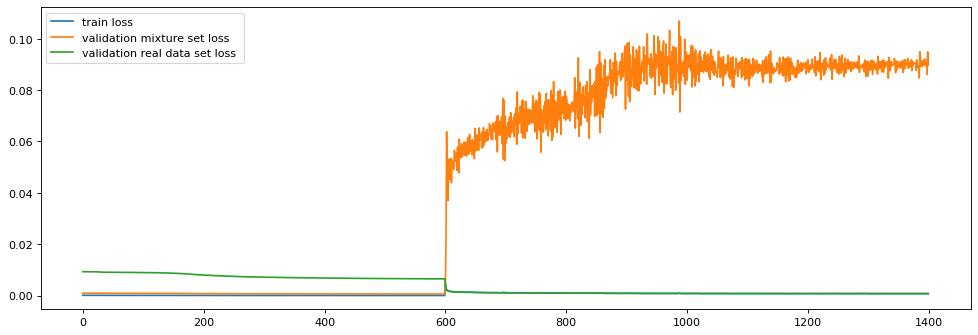

In [ ]:
plot_loss_2(history_5_8_10_de_mix)

Text(0, 0.5, 'Valeur de la MSE par pixel')

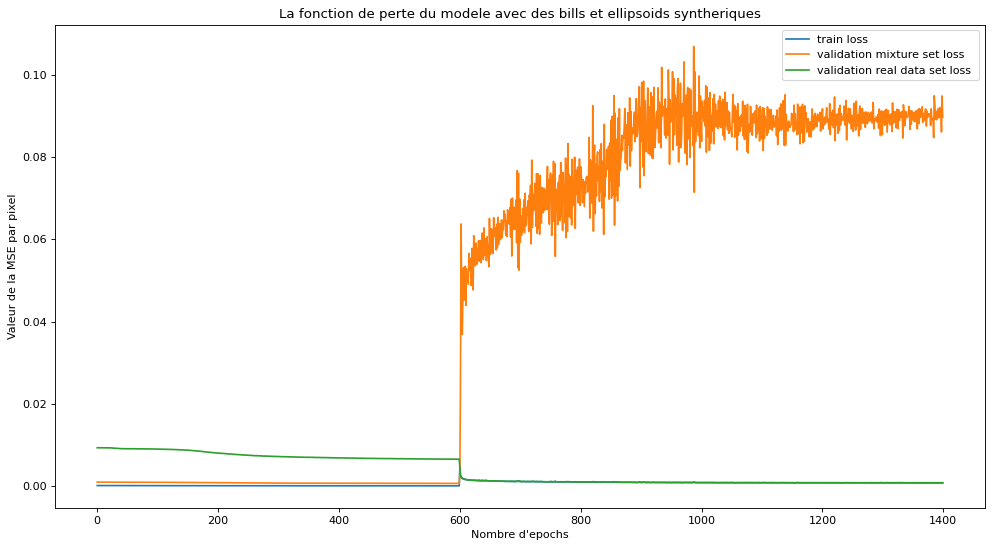

In [ ]:
figure(figsize=(15,8), dpi=80)
plt.plot(history_5_8_10_de_mix['loss_train'][:], label = "train loss")
plt.plot(history_5_8_10_de_mix['loss_val_mix'][:], label = "validation mixture set loss ")
plt.plot(history_5_8_10_de_mix['loss_val_reel'][:], label = "validation real data set loss ")
plt.legend(loc="upper right")
plt.title("La fonction de perte du modele avec des bills et ellipsoids syntheriques")
plt.xlabel("Nombre d'epochs")
plt.ylabel("Valeur de la MSE par pixel")

Text(0, 0.5, 'Valeur de la MSE par pixel en log')

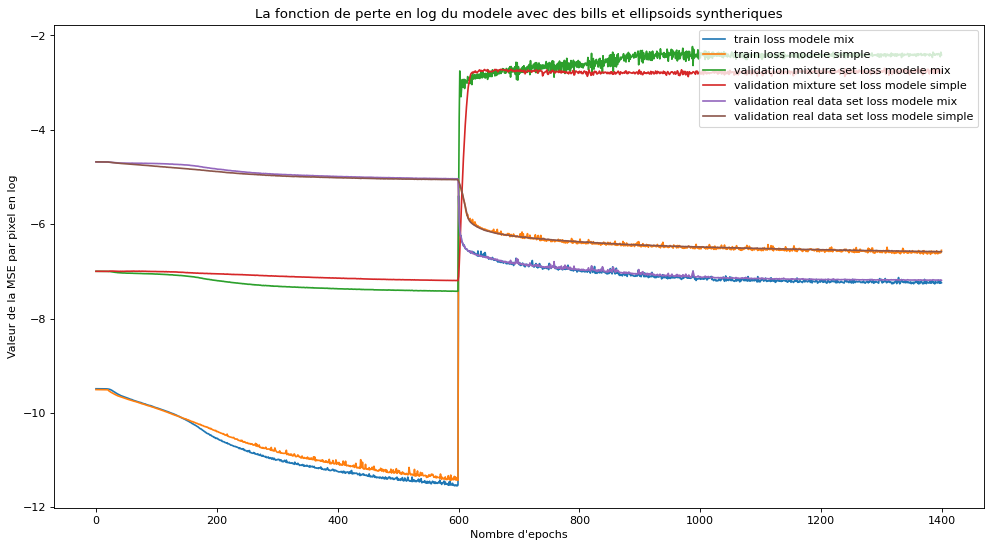

In [ ]:

figure(figsize=(15,8), dpi=80)
plt.plot(np.log(history_5_8_10_de_mix['loss_train'][:]), label = "train loss modele mix")
plt.plot(np.log(history_5_8_10_de_new['loss_train'][:]), label = "train loss modele simple")
plt.plot(np.log(history_5_8_10_de_mix['loss_val_mix'][:]), label = "validation mixture set loss modele mix")
plt.plot(np.log(history_5_8_10_de_new['loss_val_mix'][:]), label = "validation mixture set loss modele simple")
plt.plot(np.log(history_5_8_10_de_mix['loss_val_reel'][:]), label = "validation real data set loss modele mix")
plt.plot(np.log(history_5_8_10_de_new['loss_val_reel'][:]), label = "validation real data set loss modele simple")
plt.legend(loc="upper right")
plt.title("La fonction de perte en log du modele avec des bills et ellipsoids syntheriques")
plt.xlabel("Nombre d'epochs")
plt.ylabel("Valeur de la MSE par pixel en log")

In [ ]:
with torch.no_grad():
    for clean, noise in test_reel_loader:
        res_1 = dncnn3d_5_8_10_de_mix(noise.to(device))

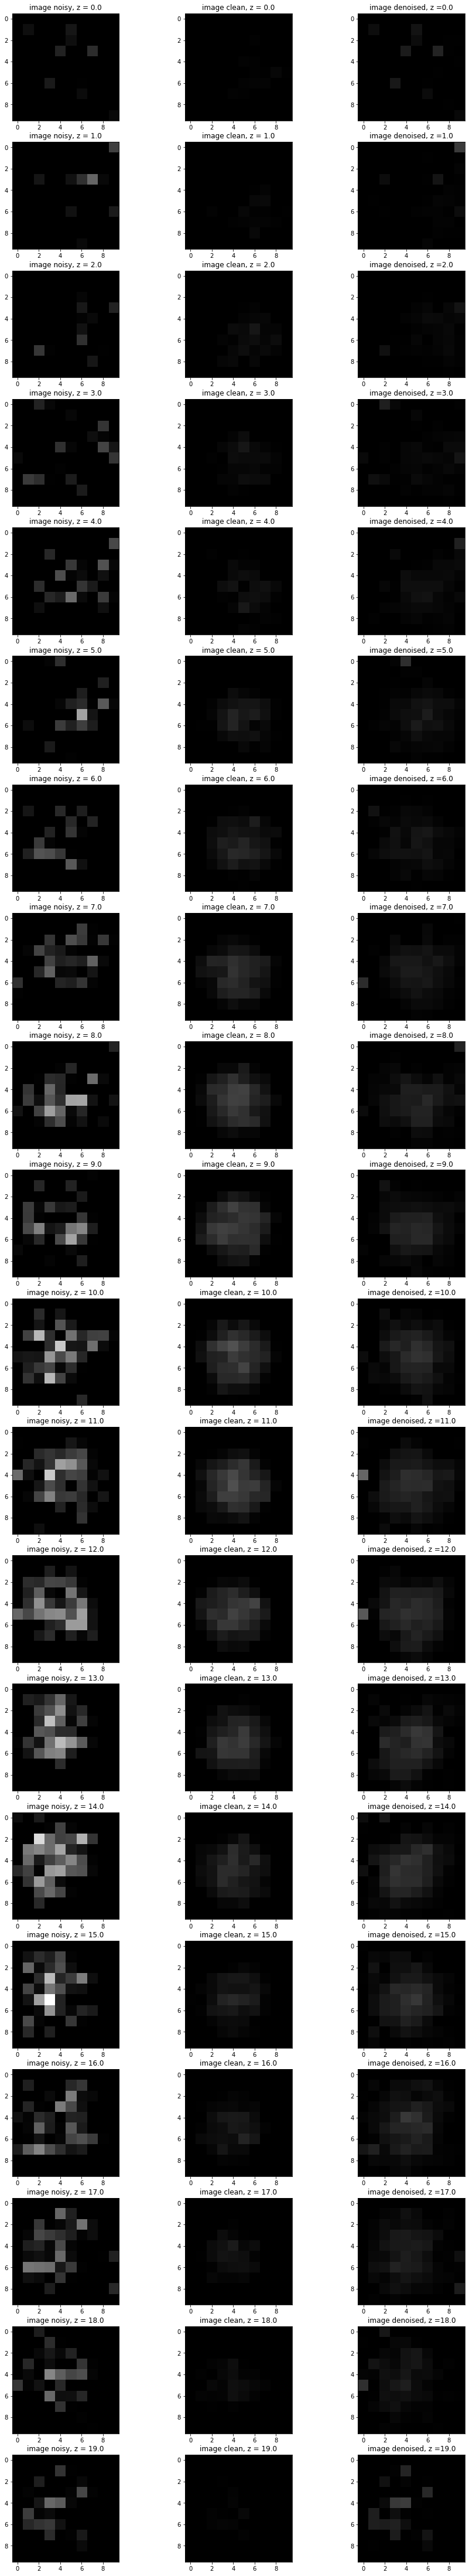

In [ ]:
disp_img_nn_res(noise[2,0], clean[2,0], res[2,0])

# direct training on the real data 

In [ ]:
dncnn3d_5_8_10_direct = DnCNN3d_de(nc = 5, num_of_layers = 8).to(device)
criterion = nn.MSELoss(size_average = True)
history_dncnn = {'loss_train' : [], 'loss_val_mix': [], 'loss_val_reel':[]}

history_5_8_10_direct = train(history_dncnn, dncnn3d_5_8_10_direct, train_real_loader_5, val_mix_loader, val_reel_loader,
                              nb_epoch = 1500 ,lr_new = 0.0001,lr_update = "plateau", gam = 0.92, early_stop = False )

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


one epoch time = 1.03e-01 seconds
epoch 1 with loss train 9.14e-03, loss validition mix= 9.12e-04, loss validition reel= 9.24e-03
epoch 50 : loss train 6.59e-03, loss validition mix = 4.21e-02, loss validition reel= 6.78e-03, Current learning rate 1.00e-04
epoch 100 : loss train 6.50e-03, loss validition mix = 4.19e-02, loss validition reel= 6.44e-03, Current learning rate 1.00e-04
epoch 150 : loss train 6.12e-03, loss validition mix = 6.45e-02, loss validition reel= 6.09e-03, Current learning rate 1.00e-04
epoch 200 : loss train 5.75e-03, loss validition mix = 5.99e-02, loss validition reel= 5.78e-03, Current learning rate 1.00e-04
epoch 250 : loss train 5.38e-03, loss validition mix = 5.38e-02, loss validition reel= 5.37e-03, Current learning rate 1.00e-04
epoch 300 : loss train 4.86e-03, loss validition mix = 5.14e-02, loss validition reel= 4.99e-03, Current learning rate 1.00e-04
epoch 350 : loss train 4.36e-03, loss validition mix = 5.85e-02, loss validition reel= 4.39e-03, Curren

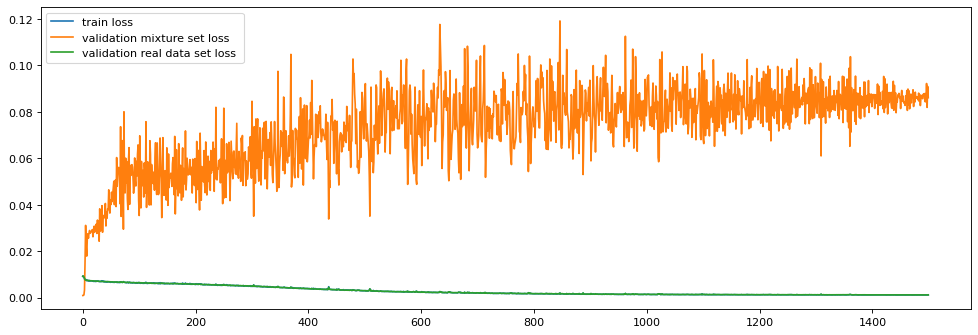

In [ ]:
plot_loss_2(history_5_8_10_direct)

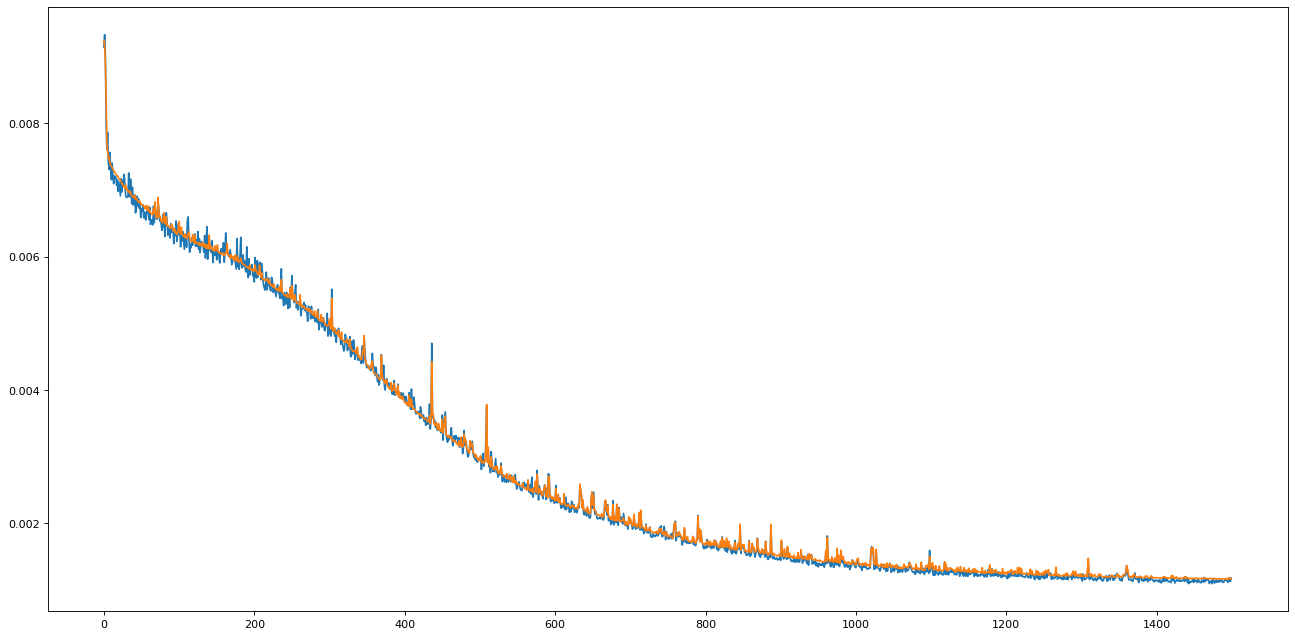

In [ ]:
figure(figsize=(20,10), dpi=80)
plt.plot(history_5_8_10_direct['loss_train'][:])
#plt.plot(history_5_8_10_de_new['loss_val_mix'][400:])
plt.plot(history_5_8_10_direct['loss_val_reel'][:])

Text(0, 0.5, 'Valeur de la MSE par pixel en log')

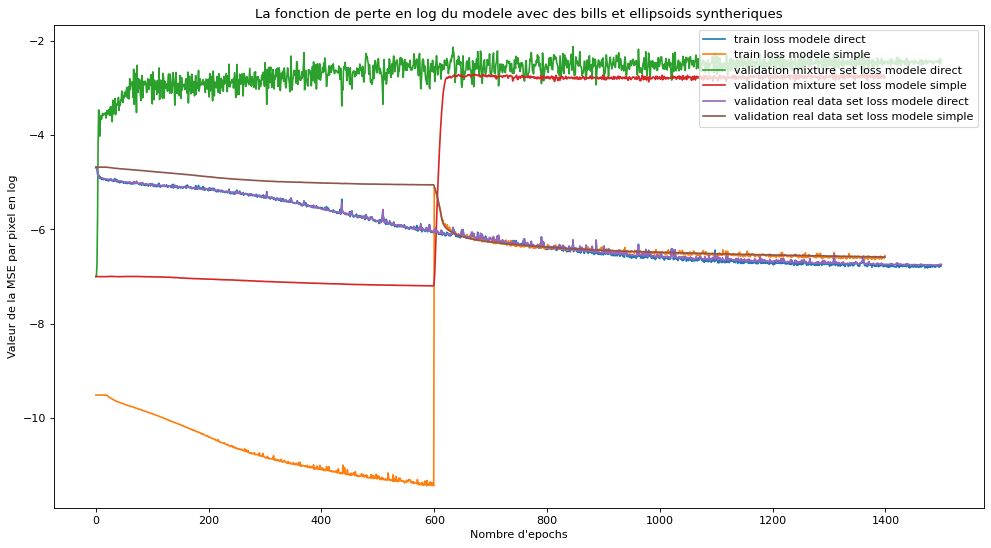

In [ ]:
figure(figsize=(15,8), dpi=80)
plt.plot(np.log(history_5_8_10_direct['loss_train'][:]), label = "train loss modele direct")
plt.plot(np.log(history_5_8_10_de_new['loss_train'][:]), label = "train loss modele simple")
plt.plot(np.log(history_5_8_10_direct['loss_val_mix'][:]), label = "validation mixture set loss modele direct")
plt.plot(np.log(history_5_8_10_de_new['loss_val_mix'][:]), label = "validation mixture set loss modele simple")
plt.plot(np.log(history_5_8_10_direct['loss_val_reel'][:]), label = "validation real data set loss modele direct")
plt.plot(np.log(history_5_8_10_de_new['loss_val_reel'][:]), label = "validation real data set loss modele simple")
plt.legend(loc="upper right")
plt.title("La fonction de perte en log du modele avec des bills et ellipsoids syntheriques")
plt.xlabel("Nombre d'epochs")
plt.ylabel("Valeur de la MSE par pixel en log")

In [ ]:
with torch.no_grad():
    for clean, noise in test_reel_loader:
      res = dncnn3d_5_8_10_de_new(noise.to(device))
      res_1 = dncnn3d_5_8_10_de_mix(noise.to(device))
      res_2 = dncnn3d_5_8_10_direct(noise.to(device))

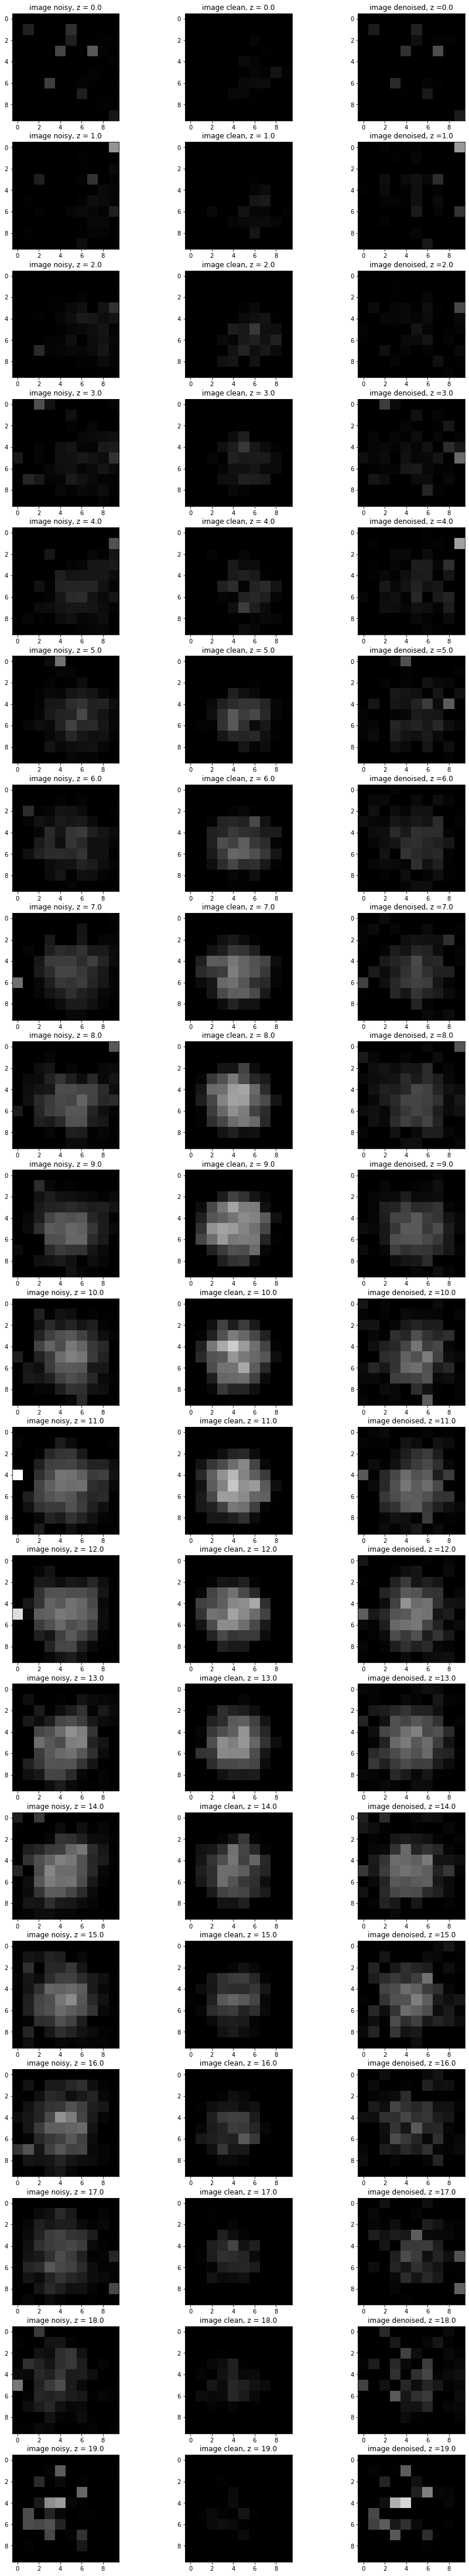

In [ ]:
disp_img_nn_res(res[2,0], clean[2,0], res_2[2,0])

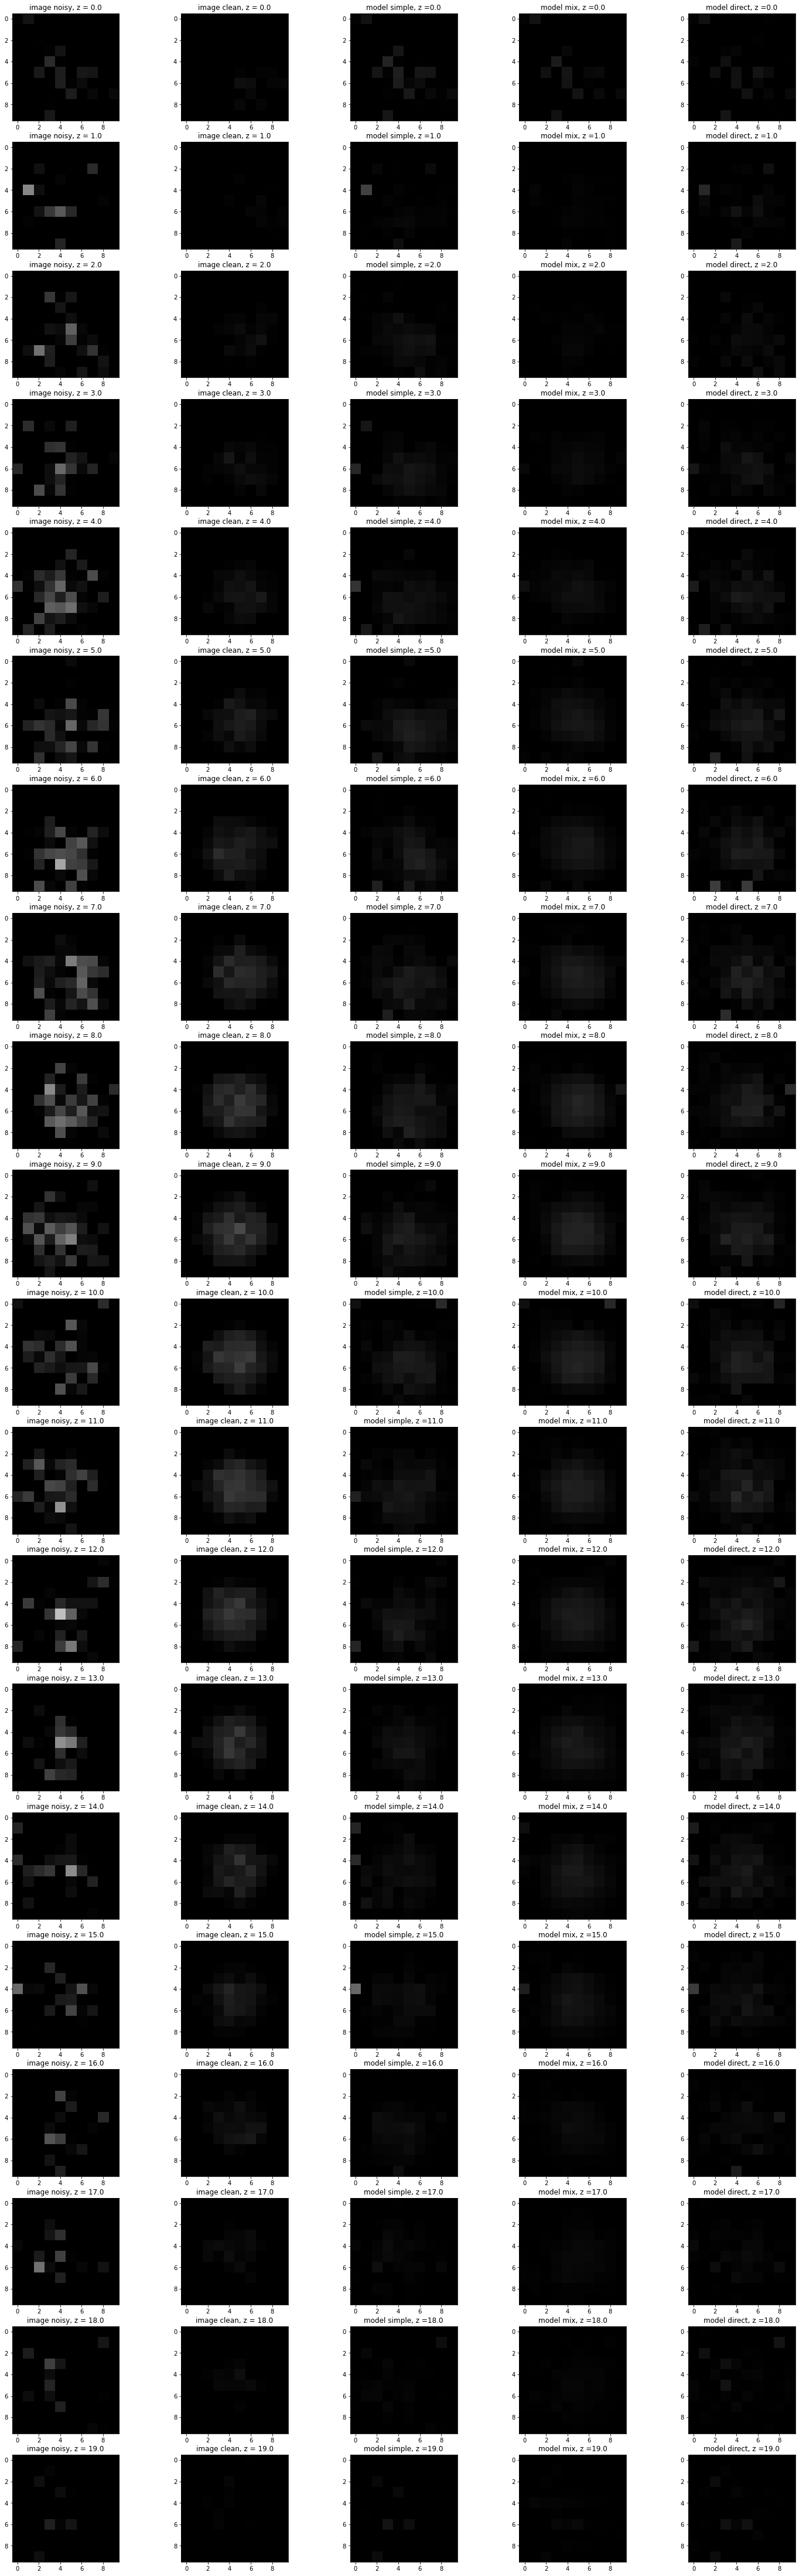

In [ ]:
    bruit_cpu = noise.cpu().detach().numpy()
    clean_cpu = clean.cpu().detach().numpy()
    res_cpu = res.cpu().detach().numpy()
    res_mix = res_1.cpu().detach().numpy()
    res_dir = res_2.cpu().detach().numpy()

    v_min = min(min(bruit_cpu.flat), min(clean_cpu.flat), min(res_cpu.flat))
    v_max = max(max(bruit_cpu.flat), max(clean_cpu.flat), max(res_cpu.flat),max(res_mix.flat),max(res_dir.flat))
    fig, axs = plt.subplots(20,5, figsize=(25, 80)) #fig, axs = plt.subplots(10,6, figsize=(25, 40))
    axs = axs.ravel()
    #v_max = max(max(bruit.flat), max(clean.flat), max(res.flat))
    for count in range(0, 100, 5):
        #v_min = min(min(bruit[int(count/3)].flat), min(clean[int(count/3)].flat), min(res[int(count/3)].flat))
        #v_max = max(max(bruit[int(count/3)].flat), max(clean[int(count/3)].flat), max(res[int(count/3)].flat))
        axs[0 + count].imshow(bruit_cpu[3, 0, int(count/5)], cmap = 'gray' , vmin = 0, vmax = v_max)
        axs[0 + count].set_title('image noisy, z = ' + str(count/5) )
        axs[1 + count].imshow(clean_cpu[3, 0, int(count/5)], cmap = 'gray', vmin = 0, vmax = v_max)
        axs[1 + count].set_title('image clean, z = '+ str(count/5))
        axs[2 + count].imshow(res_cpu[3, 0, int(count/5)], cmap = 'gray', vmin = 0, vmax = v_max)
        axs[2 + count].set_title('model simple'+', z ='+ str(count/5))

        axs[3 + count].imshow(res_mix[3, 0, int(count/5)], cmap = 'gray', vmin = 0, vmax = v_max)
        axs[3 + count].set_title('model mix'+', z ='+ str(count/5))
        axs[4 + count].imshow(res_dir[3, 0, int(count/5)], cmap = 'gray', vmin = 0, vmax = v_max)
        axs[4 + count].set_title('model direct'+', z ='+ str(count/5))


In [ ]:
def detach_img (img):
  img_cpu = img.cpu().detach().numpy()
  return(img_cpu)

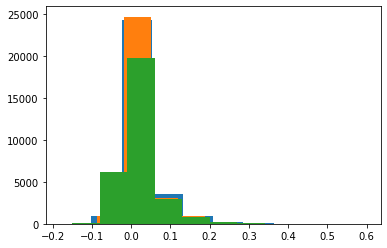

In [ ]:
_ = plt.hist(res_cpu.flatten())
_ = plt.hist(res_mix.flatten())
_ = plt.hist(res_dir.flatten())

In [ ]:
fig, axs = plt.subplots(8,10, figsize=(25,15))
axs = axs.ravel()
res_de, res_1_de, res_2_de = map(detach_img, [res, res_1, res_2])
for z in range(20):
    axs[z].imshow(res_de[0,0, z], cmap = 'gray' , vmin = 0, vmax = 0.3)
    axs[z+20].imshow(res_1_de[0, 0, z],cmap = 'gray' , vmin = 0, vmax = 0.4)
    axs[z+40].imshow(res_2_de[0, 0, z], cmap = 'gray' , vmin = 0, vmax = 0.4)
    axs[z+60].imshow(clean[0, 0, z], cmap = 'gray' , vmin = 0, vmax = 0.4)